In [19]:
import csv
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib as mpl
import datetime

# Load tow logs from the City of Cambridge website

In [20]:
#https://data.cambridgema.gov/Public-Safety/Tow-Log/aa6j-h24p
df = pd.read_csv('/Users/esilvert/Desktop/parking2/tza/data/cambridge_tow_log.csv')
print(len(df))
col_l = ['Classification','Location','State','Make','Model','Color','TowedBy','Reason']
for col in col_l:
    df[col] = df[col].str.strip()
    
#See value counts by column

# for col in df.columns:
#     unique_vals = df[col].nunique()
#     missing_count = df[col].isna().sum()
#     print('{}; missing count: {}'.format(col,missing_count))

#     if unique_vals<.1*len(df):
#         print(unique_vals)
#         value_counts = df[col].value_counts().reset_index()
#         if col == 'Classification':
#             value_counts.to_csv('tow_')
#         display(value_counts)
#     else:
#         print(unique_vals)


88816


In [15]:
#manually categorize tow reason descriptions
# summary = df.Classification.value_counts().reset_index().rename({'index':'reason','Classification':'count'})
# print(len(summary))
# summary.to_csv('towing_reason_value_counts.csv',index=False)

#load manual categorization of tow reason descriptions
reason_categories = pd.read_csv('towing_reason_value_counts.csv')
reason_categories.loc[reason_categories['Reason category'].isna(),'Reason category'] = 'Unknown'
reason_categories['Reason category'].isna().sum()
print(len(df))
df_merged = df.merge(reason_categories[['Classification','Reason category']], on ='Classification', how= 'left')
other = ['Unknown','Parking issue','No license plate','Accident','Larceny','Fire','Arrest','Car stopped']
df_merged.loc[df_merged['Reason category'].isin(other),'Reason category'] = 'Other'
df_merged.loc[df_merged['Reason category'].str.contains('Obstructing'),'Reason category'] = 'Obstructing'
towing_reasons = df_merged['Reason category'].unique().tolist()
df_merged['Reason category'].value_counts().reset_index()
# df['TowedDateTime'] = pd.to_datetime(df['TowedDateTime']).dt.date
# df = df[df['TowedDateTime']<=datetime.date(2021,11,30)]
# print(df['TowedDateTime'].min(),df['TowedDateTime'].max())


80873


,index,Reason category
0,Street cleaning,50527
1,Private property,12124
2,Other,8238
3,Obstructing,7728
4,Snow,1106
5,Explicit tow zone,696
6,Fire hydrant,454


In [11]:
# print(len(df))
# more_than_x_associated_rows = 0
# for tracking_num,group in df.groupby('TrackingNumber'):
#     if len(group)>10:
#         print(len(group))
#         display(group.head(10))
#         more_than_x_associated_rows+=1
# print(more_than_x_associated_rows)

# Load parking ticket data from the City of Cambridge website

In [10]:
df_tickets = pd.read_csv('/Users/esilvert/Desktop/parking2/tza/data/Cambridge_Parking_Tickets.csv')
print(len(df_tickets))
col_l = ['Meter','Violation Description','Location','Department']
for col in col_l:
    df_tickets[col] = df_tickets[col].str.strip()
df_tickets['Ticket Issue Date'] = pd.to_datetime(df_tickets['Ticket Issue Date']).dt.date
df_tickets = df_tickets[df_tickets['Ticket Issue Date']>=datetime.date(2015,1,1)]
print(df_tickets['Ticket Issue Date'].min(),df_tickets['Ticket Issue Date'].max())

#manually categorize ticket descriptions
# summary = df['Violation Description'].value_counts().reset_index()
# summary.to_csv('ticket_value_counts.csv',index=False)
# print(len(summary))

#load manual categorization of tickets
ticket_categories = pd.read_csv('ticket_value_counts.csv')
print(len(df_tickets))
df_tickets_merged = df_tickets.merge(ticket_categories[['Violation Description','Violation category']], on ='Violation Description', how= 'left')
df_tickets_merged = df_tickets_merged[df_tickets_merged['Violation category'].isin(['Street cleaning','Snow'])]
df_tickets_merged.head(2)


/var/folders/0d/jjh713y94rs8q4jlcqnd2_c00000gr/T/ipykernel_64329/3373940175.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_tickets = pd.read_csv('/Users/esilvert/Desktop/parking2/tza/data/Cambridge_Parking_Tickets.csv')


2181511
2015-01-01 2021-11-30
1878731


,Ticket Issue Date,Issue Time,Meter,Violation Description,Location,Department,Violation category
7,2020-09-03,09:04,NaN,STREET CLE,NaN,NaN,Street cleaning
8,2018-09-18,1899-12-31T09:07:00.000,NaN,STREET CLE,NaN,Police,Street cleaning


# Towing reasons line plots

In [16]:
def make_grid(df, col, values):
    l = []
    for date,group in df.groupby('TowedDateTime'):
        
        tickets_by_date = df_tickets_merged[df_tickets_merged['Ticket Issue Date']==date]
        if col == 'Reason category':
            daily_cleaning_tickets = (tickets_by_date[tickets_by_date['Violation category']=='Street cleaning'])
            daily_snow_tickets = (tickets_by_date[tickets_by_date['Violation category']=='Snow'])
            
            day_l = [date,len(group),len(daily_cleaning_tickets),len(daily_snow_tickets)]
            values1 = ['Street cleaning_tickets','Snow_tickets']+values
        else:
            day_l = [date,len(tickets_by_date)]            
        for val in values:
            
            day_l.append(len(group[group[col]==val]))
        l.append(day_l)
        
    daily_counts = pd.DataFrame(l,columns=['Date','Total']+values1)
    for val in ['Total']+values1:
        daily_counts[val+'_cumSum'] = daily_counts[val].cumsum()
    return daily_counts

        

# grid = make_grid(df_merged,'Reason category',towing_reasons)



,Date,Total,Street cleaning_tickets,Snow_tickets,Private property,Other,Obstructing,Explicit tow zone,Fire hydrant,Snow,Street cleaning,Total_cumSum,Street cleaning_tickets_cumSum,Snow_tickets_cumSum,Private property_cumSum,Other_cumSum,Obstructing_cumSum,Explicit tow zone_cumSum,Fire hydrant_cumSum,Snow_cumSum,Street cleaning_cumSum
0,2015-01-01,16,0,0,7,9,0,0,0,0,0,16,0,0,7,9,0,0,0,0,0
1,2015-01-02,8,0,0,3,0,4,1,0,0,0,24,0,0,10,9,4,1,0,0,0
2,2015-01-03,5,0,0,3,0,2,0,0,0,0,29,0,0,13,9,6,1,0,0,0
3,2015-01-04,4,0,0,1,1,2,0,0,0,0,33,0,0,14,10,8,1,0,0,0
4,2015-01-05,8,0,0,2,2,2,2,0,0,0,41,0,0,16,12,10,3,0,0,0


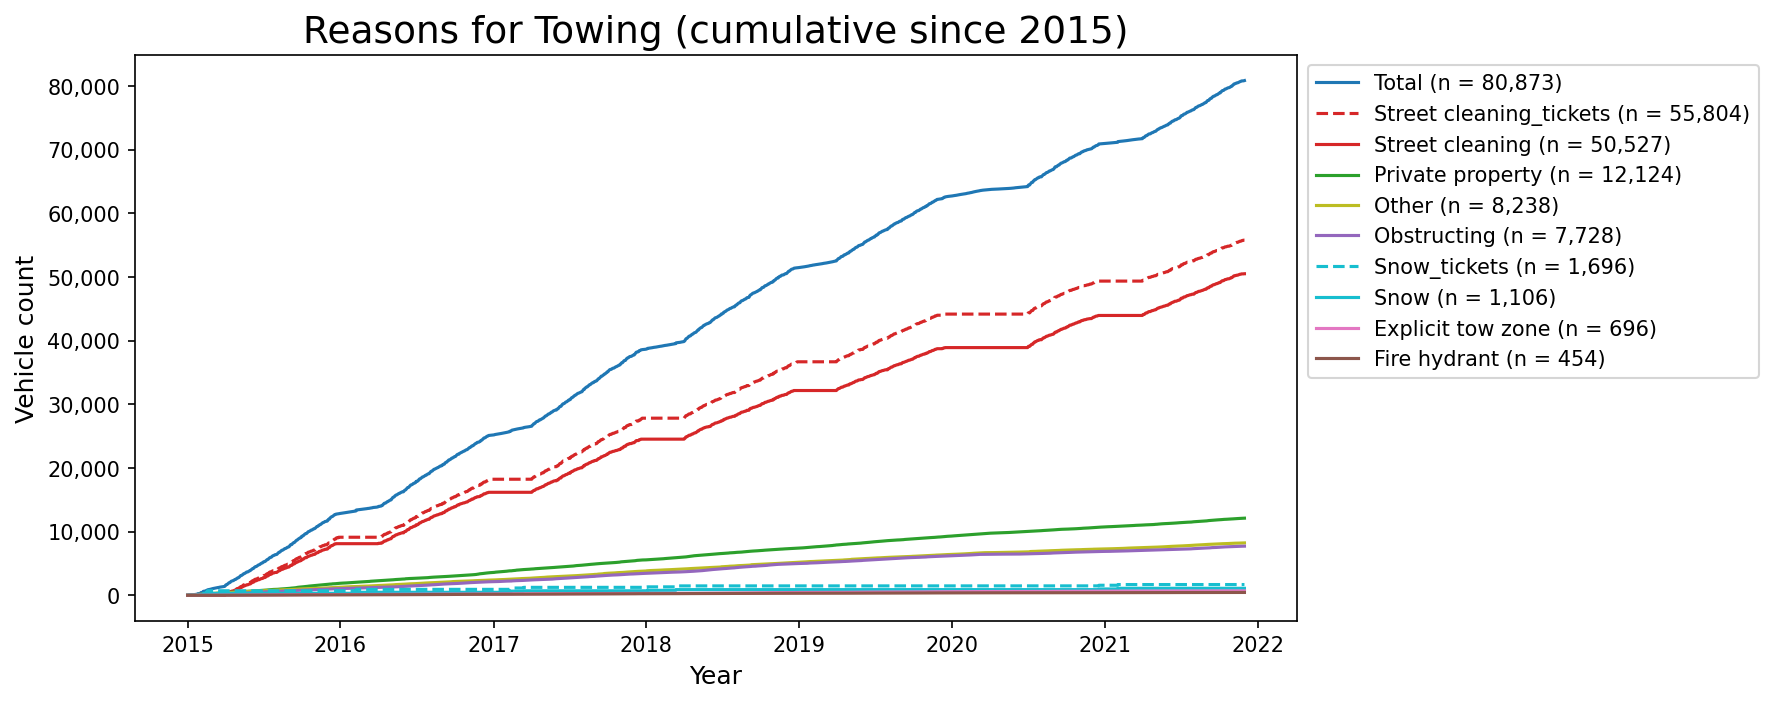

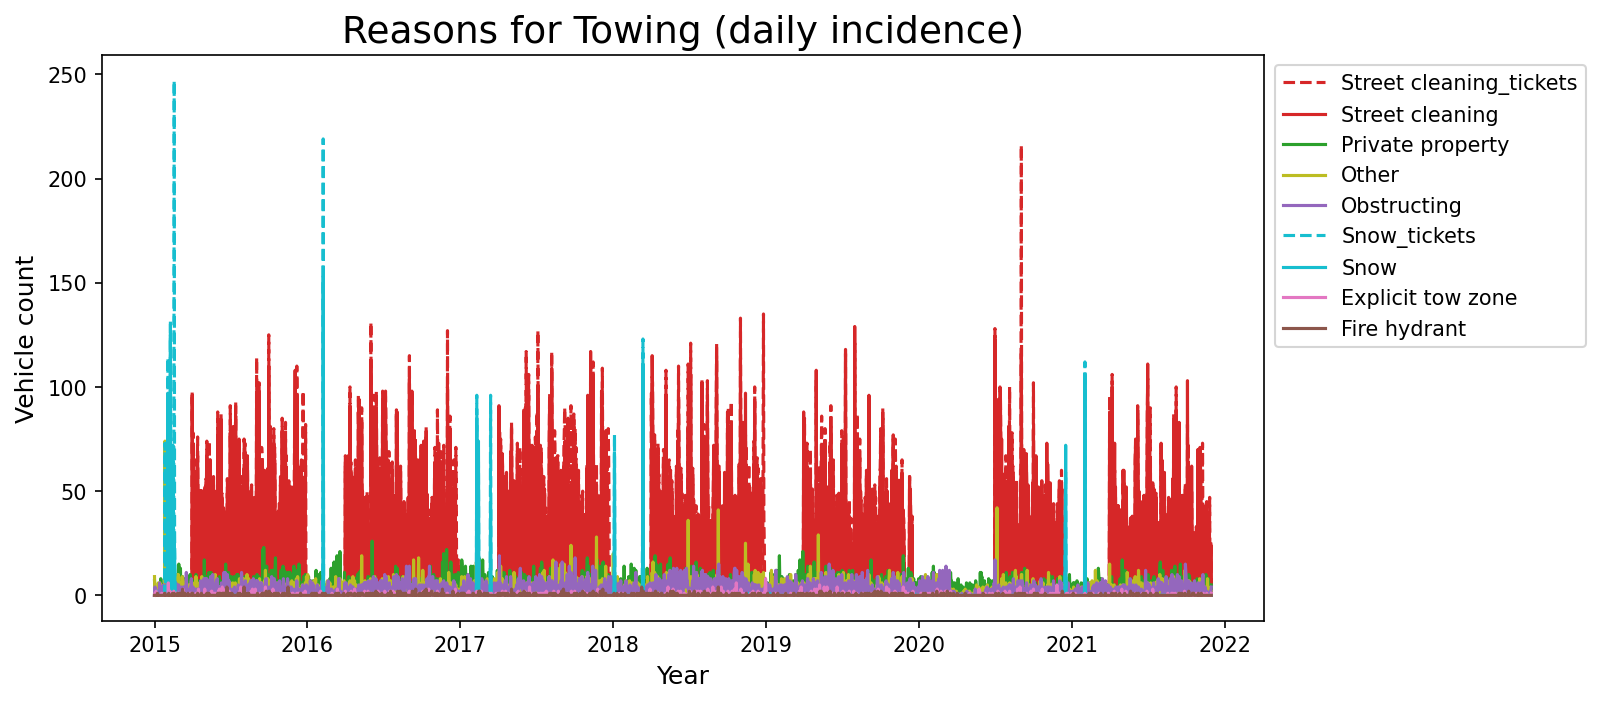

In [18]:
mpl.rcParams['figure.dpi'] = 150

def make_reasons_graph(df,col, values,title,cum=True):
    grid = make_grid(df,col, values)
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 5)
    dates = grid['Date'].tolist()
    
    if cum:
        
        val = 'Total'
        counts = grid[val+'_cumSum'].tolist()
        plt.plot(dates,counts,color='tab:blue',label = '{} (n = {:,})'.format(val,counts[-1]))
        
        val = 'Street cleaning_tickets'
        counts = grid[val+'_cumSum'].tolist()
        plt.plot(dates,counts,color='tab:red',linestyle='dashed',label = '{} (n = {:,})'.format(val,counts[-1]))        
        
        val = 'Street cleaning'
        counts = grid[val+'_cumSum'].tolist()
        plt.plot(dates,counts,color='tab:red',label = '{} (n = {:,})'.format(val,counts[-1]))        
                      
        val = 'Private property'
        counts = grid[val+'_cumSum'].tolist()
        plt.plot(dates,counts,color='tab:green',label = '{} (n = {:,})'.format(val,counts[-1]))        
              
        val = 'Other'
        counts = grid[val+'_cumSum'].tolist()
        plt.plot(dates,counts,color='tab:olive',label = '{} (n = {:,})'.format(val,counts[-1])) 
        
        val = 'Obstructing'
        counts = grid[val+'_cumSum'].tolist()
        plt.plot(dates,counts,color='tab:purple',label = '{} (n = {:,})'.format(val,counts[-1])) 
        
        val = 'Snow_tickets'
        counts = grid[val+'_cumSum'].tolist()
        plt.plot(dates,counts,color='tab:cyan',linestyle='dashed',label = '{} (n = {:,})'.format(val,counts[-1]))        
        
        val = 'Snow'
        counts = grid[val+'_cumSum'].tolist()
        plt.plot(dates,counts,color='tab:cyan',label = '{} (n = {:,})'.format(val,counts[-1])) 
        
        val = 'Explicit tow zone'
        counts = grid[val+'_cumSum'].tolist()
        plt.plot(dates,counts,color='tab:pink',label = '{} (n = {:,})'.format(val,counts[-1])) 
                
        val = 'Fire hydrant'
        counts = grid[val+'_cumSum'].tolist()
        plt.plot(dates,counts,color='tab:brown',label = '{} (n = {:,})'.format(val,counts[-1])) 
                

    else:

        val = 'Street cleaning_tickets'
        counts = grid[val].tolist()
        plt.plot(dates,counts,color='tab:red',linestyle='dashed',label = val)        
        
        val = 'Street cleaning'
        counts = grid[val].tolist()
        plt.plot(dates,counts,color='tab:red',label = val)        
                      
        val = 'Private property'
        counts = grid[val].tolist()
        plt.plot(dates,counts,color='tab:green',label = val)        
              
        val = 'Other'
        counts = grid[val].tolist()
        plt.plot(dates,counts,color='tab:olive',label = val) 
        
        val = 'Obstructing'
        counts = grid[val].tolist()
        plt.plot(dates,counts,color='tab:purple',label = val) 
        
        val = 'Snow_tickets'
        counts = grid[val].tolist()
        plt.plot(dates,counts,color='tab:cyan',linestyle='dashed',label = val)        
        
        val = 'Snow'
        counts = grid[val].tolist()
        plt.plot(dates,counts,color='tab:cyan',label = val) 
        
        val = 'Explicit tow zone'
        counts = grid[val].tolist()
        plt.plot(dates,counts,color='tab:pink',label = val) 
                
        val = 'Fire hydrant'
        counts = grid[val].tolist()
        plt.plot(dates,counts,color='tab:brown',label = val) 
               
            
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    plt.xlabel('Year',size=12)
    plt.ylabel('Vehicle count',size=12)
#     plt.ylim(0,2000)
#     ax.set_yscale('log')
    plt.title(title,size=18)
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()
    
towing_reasons = df_merged['Reason category'].value_counts().reset_index()['index'].tolist()
make_reasons_graph(df_merged,'Reason category',towing_reasons,'Reasons for Towing (cumulative since 2015)', cum=True)
make_reasons_graph(df_merged,'Reason category',towing_reasons,'Reasons for Towing (daily incidence)', cum=False)


In [100]:
mpl.rcParams['figure.dpi'] = 150

def make_graph(df,col, values,title,cum=True):
    grid = make_grid(df,col, values)
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 5)
    dates = grid['Date'].tolist()
    
    if cum:
        for val in ['Total','Street cleaning_tickets','Snow_tickets']+values:

                

            counts = grid['Street cleaning'+'_cumSum'].tolist()
            plt.plot(dates, counts,label = '{} (n = {:,})'.format(val,counts[-1]))
        
            max_count = counts[-1]
            if 'tickets' in val:
                plt.plot(dates, counts, linestyle = 'dashed',label = '{} (n = {:,})'.format(val,max_count))
            else:
                plt.plot(dates, counts, label = '{} (n = {:,})'.format(val,max_count))
    else:
        for val in values:
            counts = grid[val].tolist()
            dates = grid['Date'].tolist()
            plt.plot(dates, counts, label = val)
            
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    plt.xlabel('Year',size=12)
    plt.ylabel('Towed vehicle count',size=12)
#     plt.ylim(0,2000)
#     ax.set_yscale('log')
    plt.title(title,size=18)
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

make_graph(df_merged,'Reason category',towing_reasons,'Reasons for Towing (cumulative since 2015)', cum=True)
make_graph(df_merged,'Reason category',towing_reasons,'Reasons for Towing (daily incidence)', cum=False)
#63913,2181
#1. Filter to intersecting date range
#2. Overlay ticketed cars due to street cleaning and snow

22500.0

In [39]:
df['TowedBy'].value_counts()
def towedby_map(x):
    if x in ['PHILS:CITY',"PHIL'S TOW - CITY","PHILS:PRIVATE","PHIL'S TOW - PRIVATE","--PHIL'S TOW - CITY","-PHIL'S TOW - PRIVATE"]:
        return "Phil's Towing"
    if x in ['B&B:CITY','B&B TOW - CITY','B&B:PRIVATE',"B&B TOW - PRIVATE","--B&B TOW - CITY","-B&B TOW - PRIVATE"]:
        return 'B&B Towing'
    if x in ['PATS:PRIVATE',"PAT'S TOW - PRIVATE","PAT'S TOW - CITY","--PAT'S TOW - CITY","-PAT'S TOW - PRIVATE"]:
        return "Pat's Towing"
    if x in ["ROBRT:PRIVATE","ROBERTS TOW - PRIVATE"]:
        return "Robert's Towing"
    if x in ["ABC:PRIVATE","ABC TOW -  PRIVATE"]:
        return "ABC Towing"
    if x in ["OTR:PRIVATE TOW-SEE REA","OTHER PRIVATE TOW-SEE REA","BOST:PRIVATE","BOSTONIAN TOW - PRIVATE","DWNT:PRIVATE"]:
        return "Other"
    
df["TowedBy_grouped"] = df["TowedBy"].apply(lambda x: towedby_map(x))
print(df['TowedBy_grouped'].isna().sum())
    

5


In [42]:
towedby_l = [i for i in df['TowedBy_grouped'].value_counts().reset_index()['index'].tolist() if type(i) is str]
print(towedby_l)

["Phil's Towing", 'B&B Towing', "Pat's Towing", 'Other', "Robert's Towing", 'ABC Towing']


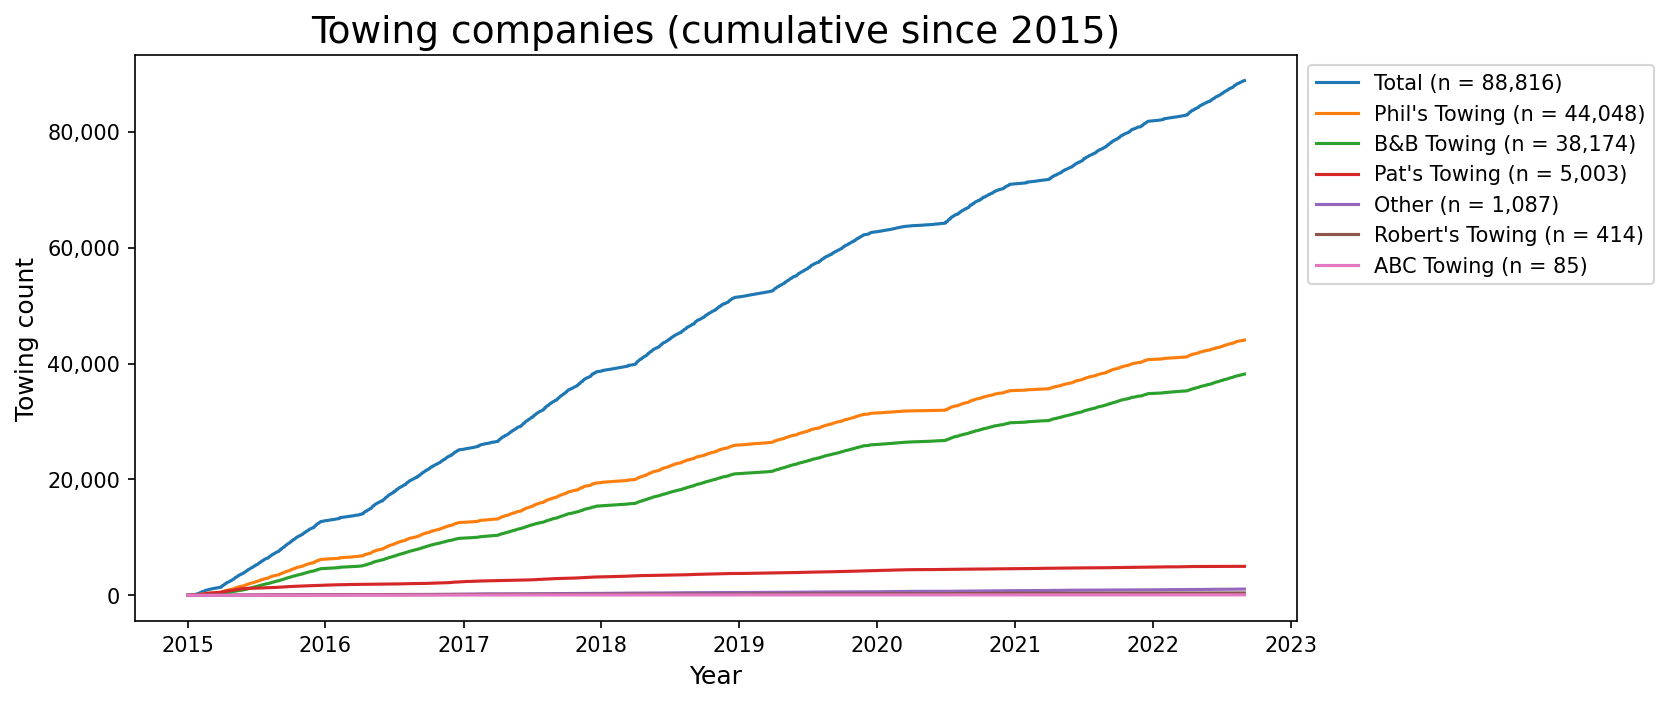

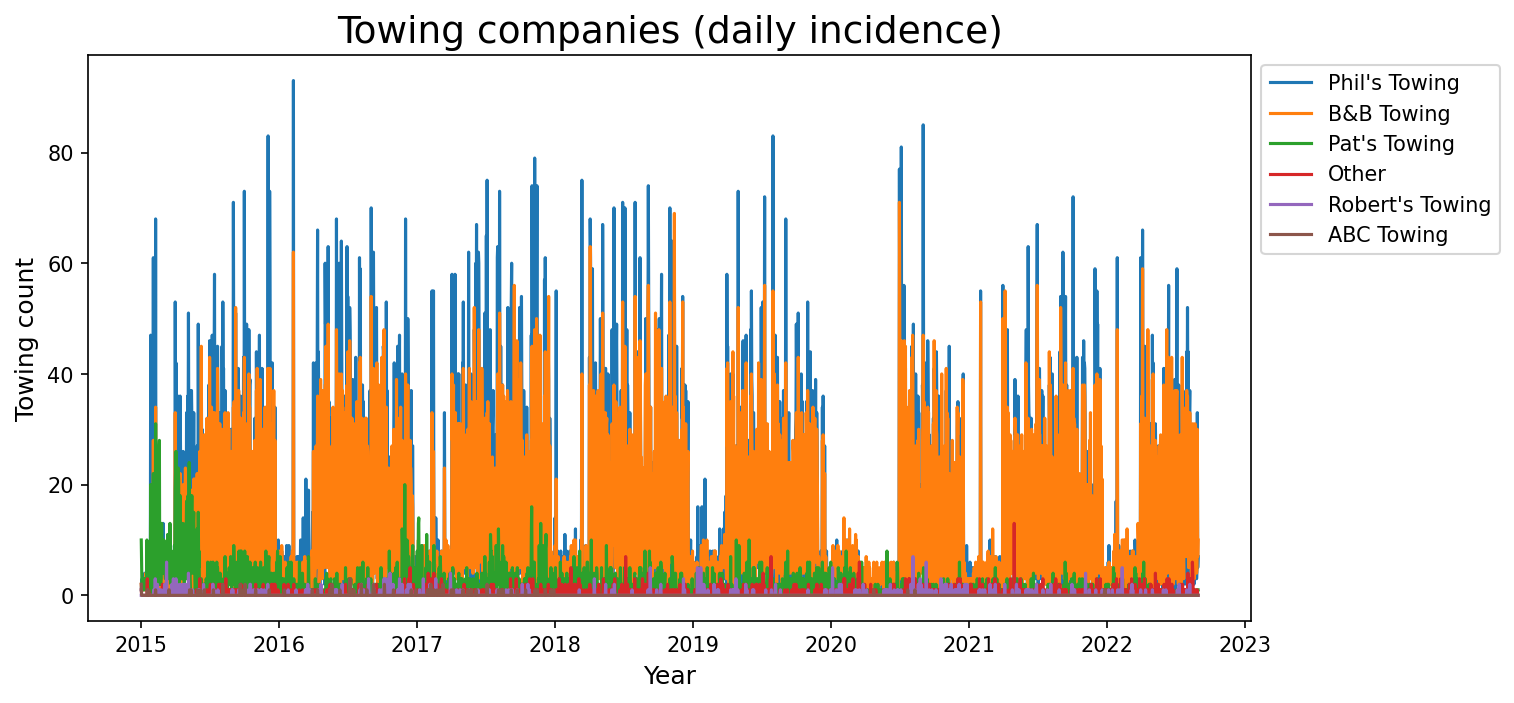

In [94]:
make_graph(df_merged,'TowedBy_grouped',towedby_l,'Towing companies (cumulative since 2015)', cum=True)
make_graph(df_merged,'TowedBy_grouped',towedby_l,'Towing companies (daily incidence)', cum=False)

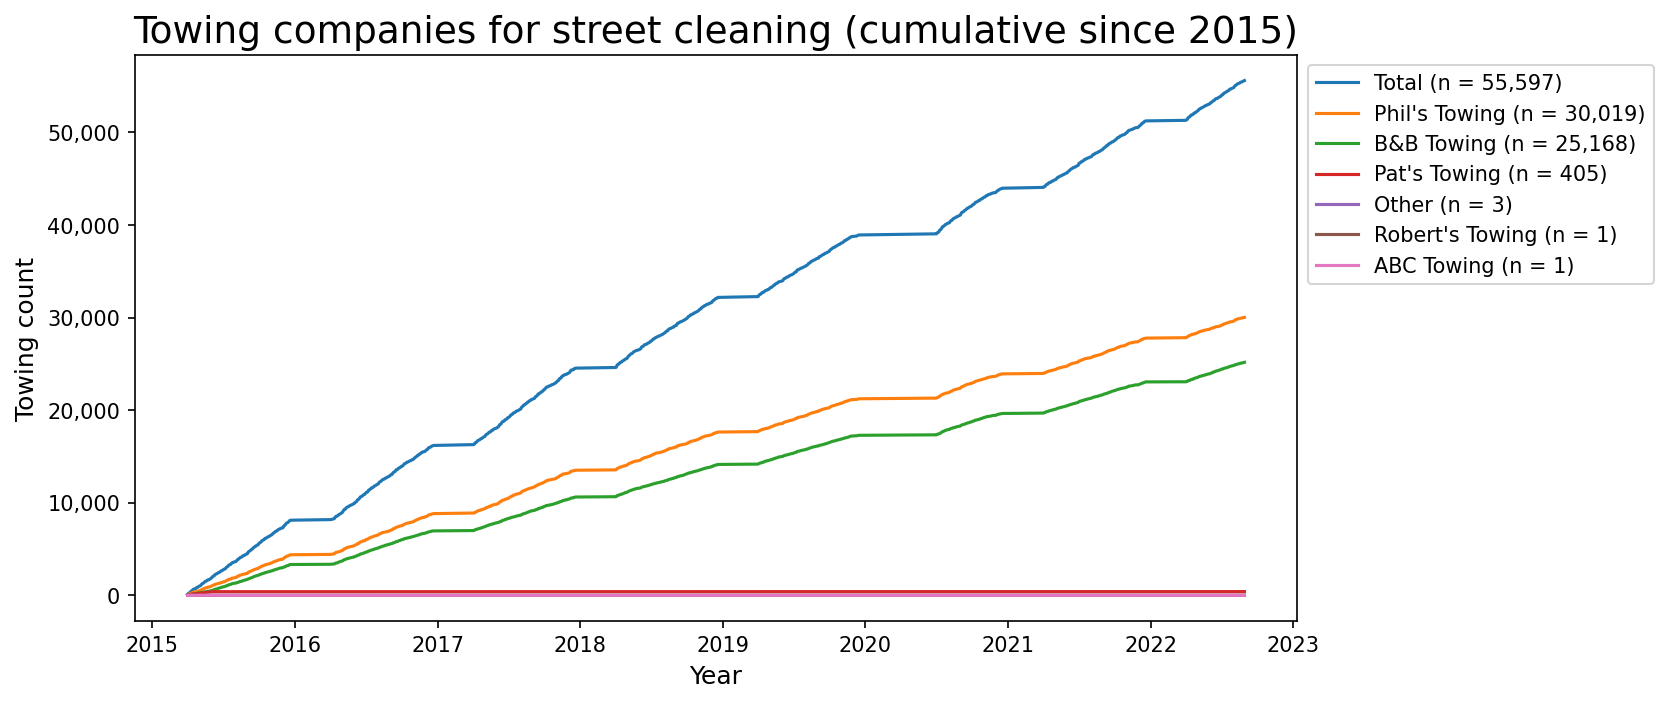

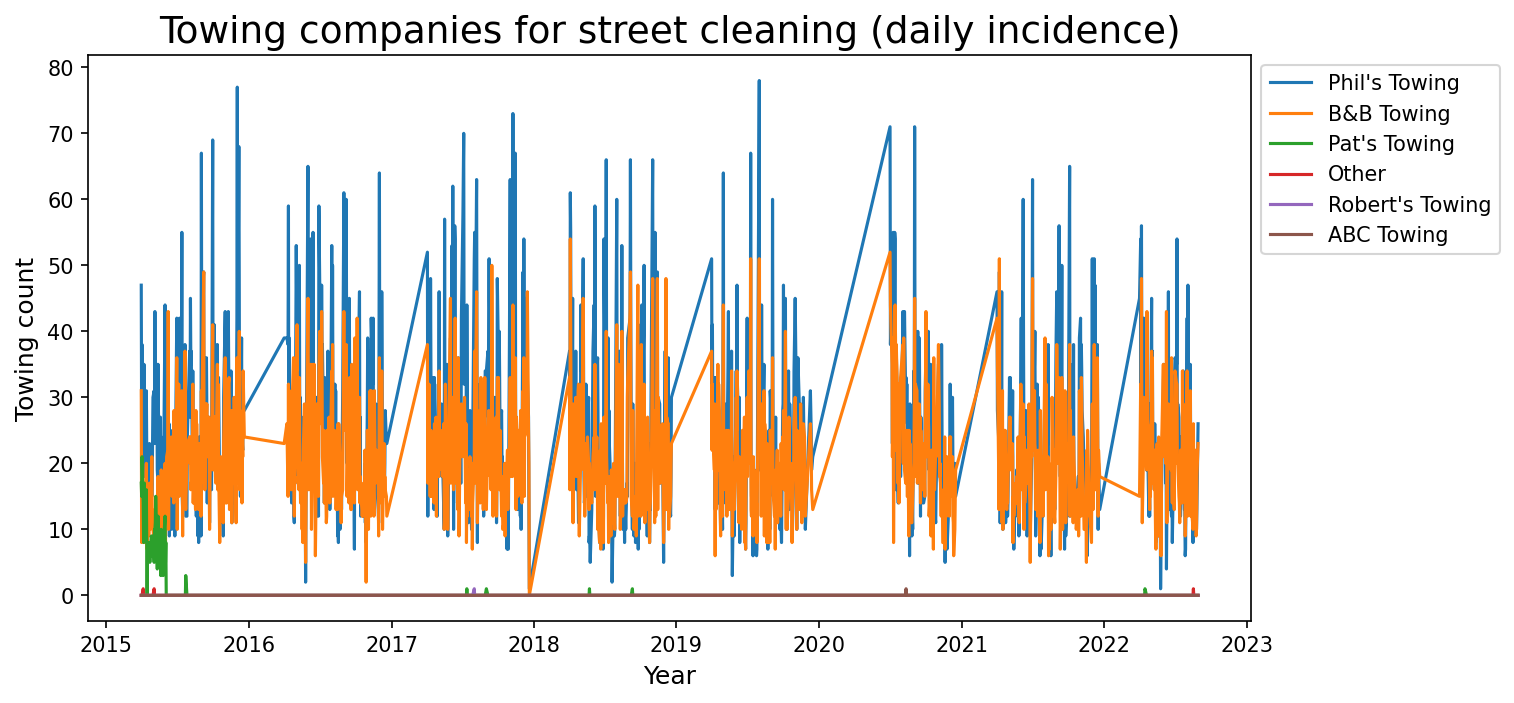

In [95]:
df_merged_cleaning_only = df_merged[df_merged['Reason category'] == 'Street cleaning']
make_graph(df_merged_cleaning_only,'TowedBy_grouped',towedby_l,'Towing companies for street cleaning (cumulative since 2015)', cum=True)
make_graph(df_merged_cleaning_only,'TowedBy_grouped',towedby_l,'Towing companies for street cleaning (daily incidence)', cum=False)

